In [1]:
import os, json
import string
import re
import pandas as pd
import numpy as np
from scipy import sparse
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

# 1. Helper Functions

Following codes define functions that are needed to load/parse Facebook data files, and transform the data.

* `parse_json`: Read json files from the path. `file_end` argument is used to filter out the mistakenly submitted files.
* `name_normal`: Normalize keywords in the data. (a) de-captitalize keywords, (b) delete punctuations, and (c) delete a single word initial in the middle (to delete middle names).
* `expand_to_df`: Expand a dictionary that contains each R's data (key: user id / value: list of keywords from the data) into a regular Pandas data frame.

IMPORTANT: `name_normal` is not applied to any of following codes to ensure the precision of the matching process. Should be applied later.

In [2]:
def parse_json(path, file_end):
    path = path + '/'
    json_files = [pos_json for pos_json in os.listdir(path) if pos_json.endswith(file_end)]
    
    out = dict()
    
    for file in json_files[0:5]:
        user_id = re.sub(file_end + "$", "", file)  # Filter files with a pariticular file end (e.g. "_pages.json")
        full_file = path + file 
        
        try:
            with open(full_file, 'r', encoding='UTF-8') as f:
                out[user_id] = json.load(f)
        except:
            continue
            
    return out

translator=str.maketrans('','',string.punctuation)

def name_normal(name):
    out = str(name).lower().translate(translator)  # (a) De-capitalize, and (b) delete punctuations.
    out = re.sub("\s[A-Za-z]\s", " ", out)    # (c) Delete single characters in the middle.
    " ".join([re.sub("\s+", "", item) for item in out.split()])
    out = re.sub("\s+$", "", out)
    
    return out

def expand_to_df(matched_keywords):
    isin_keywords = dict()
    
    potent_keywords = list(set().union(*matched_keywords.values())) # Get all the keywords that appeared in the data at least once.
    
    for key, keywords in matched_keywords.items():
        isin_keywords[key] = [item in keywords for item in potent_keywords] # Expand a list of keywords into a seriese of TRUE/FALSE.
        
    df = pd.DataFrame.from_dict(isin_keywords, orient='index', columns = potent_keywords)
    
    return df

# 2. Load Data
## 2.1. Load and Parse JSON Files

In [3]:
dt_json = parse_json("data/Qualtrics panel data/Q50", "_pages.json")

Following code transforms the loaded liked pages to a dictionary with keys being user id's and values being lists of liked pages.

In [4]:
Index = dict()

for key, value in dt_json.items():
    Index[key] = list()
    if 'page_likes' in value.keys():
        test_key = value['page_likes'][0].keys()
        
        if 'data' in test_key:        # This if clause is needed to load two different formats of JSON data.
            for item in value['page_likes']:
                Index[key].append(item['data'][0]['name'])
        else:
            for item in value['page_likes']:
                Index[key].append(item['name'])
    else:
        continue

In [5]:
dt_ads = parse_json("data/Qualtrics panel data/Q52", "_ads_interests.json")

Following code transforms the loaded advertising categories to a dictionary with keys being user id's and values being lists of advertising categories.

In [6]:
ads_topics = dict()

for key, value in dt_ads.items():
    ads_topics[key] = list()
    
    try:
        if 'topics' in value.keys():
            for item in value['topics']:
                ads_topics[key].append(item)
        else:
            continue
    except:
        continue

## 2.2. Load Dictionary

In [7]:
# Takes about a minute.
dic = pd.read_excel("Civic customization Dictionary 02-10-19.xlsx")

Transform the loaded MS Excel filte to a long list of keywords. 

In [8]:
dic = dic['Full Name'].tolist()

# 3. Matching
## 3.1.  Perfect Matching
Perfect matching simply converts two lists of keywords (a dictionary & R's keywords) into sets, and obtain intersection. The outcome is a dictionary with keys being user id and values being matched keywords.

In [9]:
def perfect_matching(dict_keyword, dic):
    matched_keywords = dict()
    dic = set(dic)  # Convert a dictionary to a set
    
    for key, value in dict_keyword.items():
        
        matched_keywords[key] = list(set(value) & dic) # (a) Convert a list of keywords into a set, and (b) Get the intersection. 
    
    return matched_keywords

In [10]:
Index_perfect = perfect_matching(Index, dic)

In [11]:
ads_topics_perfect = perfect_matching(ads_topics, dic)

In [12]:
df_Index_perfect = expand_to_df(Index_perfect)

In [13]:
df_Index_perfect

,"1,000 Days",PlayStation,JWOWW,"i play., Inc.",BarkBox,EcoVessel,ShopLivin.com,Blue Apron,Buffalo Wild Wings,Sinkboss,...,Tidy Tots Diapers,Seventh Generation,Best Buy,PureWow,Mama Strut by Pelv-Ice,Icelandair,Hawaiian Airlines,Microsoft,The Joint Chiropractic,Starbucks
R_10uxpY89ANp6Lpk,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
R_11haqA47J6Xz6uy,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
R_0kVxSmqT4eW338t,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
R_10vnVW9jokF0wMQ,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,True,False,False,True
R_08Owi7R4nr4tQo9,True,False,True,True,False,True,True,True,True,True,...,True,True,False,True,True,False,False,False,False,True


In [13]:
df_ads_topics_perfect = expand_to_df(ads_topics_perfect)

In [15]:
df_ads_topics_perfect

,Community issues,Scary Mommy,Liquid,People,Current events,Blue Apron,Marie Claire,Fish,Vacations,Artist,...,Planning,Democracy,SheaMoisture,PopSugar,Virtue,Snoop Dogg,Al Jazeera English,St. Jude Children's Research Hospital,Daily News,NBC
R_10uxpY89ANp6Lpk,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
R_0IgALa5sTzbWuDT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
R_08Owi7R4nr4tQo9,True,False,True,True,True,True,True,True,True,True,...,False,True,True,False,True,False,False,True,True,False
R_10SJJi1eOYSQQGR,True,True,True,True,False,False,False,False,False,True,...,True,False,False,True,True,True,False,False,False,True
R_0kVxSmqT4eW338t,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


## 3.2.  Fuzzy Matching
Fuzzy matching is harder: (a) It breaks every keyword and dictionary entry into a list of words (e.g. "Donald Trump" -> ["Donald", "Trump"]), and (b) if the list of words is a subset of any list of words in the dictionary (e.g. a keyword in the data: ["Donald", "Trump"] <= an entry from the dictionary: ["President", "Donald", "Trump"]), then the keyword is considered as matched.  

This process cannot entertain the efficient Python set operation to match anymore. This algorithm simply compare every single keyword in the data with every single entry in the dictionary sequentially. Suppose that 300 respondents have 500 keywords on average, and that the dictionary has 160,000 entries. Then the opertation is conduected 300 x 500 x 160,000 = 24 billion times. This is definitely where parallelizing can help reduce the computing time, but it hasn't been implemented yet.

In [14]:
def fuzzy_matching(dict_keyword, dic):
    matched_keywords = dict()
    
    for key, value in dict_keyword.items():  # For each respondent
        matched_keywords[key] = list()
        for liked_word in value:             # For each keyword in the data
            for dic_word in dic:             # For each entry in the dictionary
                if set(str(liked_word).split()) <= set(str(dic_word).split()):   # If a splitted keyword is a subset of a splitted entry  
                    matched_keywords[key].append(liked_word)  # Then add the keyword in the matched keyword list
                    break                                     # If the keyword was matched, stop matching with that keyword
    
    return matched_keywords

In [ ]:
%%time
fuzzy_matching(Index, dic)

In [ ]:
Index

# 4. Normalized Matching
* (a) normalize words
* (b) match
* (c) insert the original keyword

### To-do's:
* Parallelizing

## 4.1. Perfect Matching

In [15]:
def perfect_matching_norm(dict_keyword, dic):
    matched_keywords = dict()
    dic = [name_normal(item) for item in dic]
        
    for key, value in dict_keyword.items():
        matched_keywords[key] = list()
        for liked_word in value:             # For each keyword in the data
            if name_normal(liked_word) in dic:
                matched_keywords[key].append(liked_word)
    
    return matched_keywords

In [16]:
Index_perfect_norm = perfect_matching_norm(Index, dic)
ads_topics_perfect_norm = perfect_matching_norm(ads_topics, dic)

In [17]:
df_Index_perfect_norm = expand_to_df(Index_perfect_norm)
df_ads_topics_perfect_norm = expand_to_df(ads_topics_perfect_norm)

In [20]:
df_Index_perfect_norm

,"1,000 Days",PlayStation,JWOWW,"i play., Inc.",BarkBox,ShopLivin.com,EcoVessel,Blue Apron,Marie Claire,Sinkboss,...,Tidy Tots Diapers,Seventh Generation,Best Buy,PureWow,Mama Strut by Pelv-Ice,Icelandair,Hawaiian Airlines,Microsoft,The Joint Chiropractic,Starbucks
R_10uxpY89ANp6Lpk,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
R_11haqA47J6Xz6uy,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
R_0kVxSmqT4eW338t,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
R_10vnVW9jokF0wMQ,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,True,False,False,True
R_08Owi7R4nr4tQo9,True,False,True,True,False,True,True,True,True,True,...,True,True,False,True,True,False,False,False,False,True


In [21]:
df_ads_topics_perfect_norm

,Society,Community issues,Scary Mommy,Liquid,Education,People,Current events,Blue Apron,Marie Claire,Fish,...,Clif Bar,Human,Snoop Dogg,Al Jazeera English,Mini,Nation,St. Jude Children's Research Hospital,Daily News,NBC,Economy
R_10uxpY89ANp6Lpk,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
R_0IgALa5sTzbWuDT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
R_08Owi7R4nr4tQo9,True,True,False,True,True,True,True,True,True,True,...,False,True,False,False,True,False,True,True,False,True
R_10SJJi1eOYSQQGR,True,True,True,True,True,True,False,False,False,False,...,True,True,True,False,False,True,False,False,True,True
R_0kVxSmqT4eW338t,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


## 4.2. Fuzzy Matching

In [22]:
def fuzzy_matching_norm(dict_keyword, dic):
    matched_keywords = dict()
    dic = [name_normal(item) for item in dic]
    
    for key, value in dict_keyword.items():  # For each respondent
        matched_keywords[key] = list()
        for liked_word in value:             # For each keyword in the data
            liked_word_norm = name_normal(liked_word)
            for dic_word in dic:             # For each entry in the dictionary
                if set(str(liked_word_norm).split()) <= set(str(dic_word).split()):   # If a splitted keyword is a subset of a splitted entry  
                    matched_keywords[key].append(liked_word)  # Then add the keyword in the matched keyword list
                    break                                     # If the keyword was matched, stop matching with that keyword
    
    return matched_keywords

In [40]:
%%time
Index_fuzzy_norm = fuzzy_matching_norm(Index, dic)

In [42]:
df_Index_fuzzy_norm = expand_to_df(Index_fuzzy_norm)

In [43]:
df_Index_fuzzy_norm

,Logan,Bumbleride,Love is a Rainbow,Icelandair,PureWow,RuneScape,Norwegian,ShopLivin.com,Primary.com,Target,...,United With Israel,Tidy Tots Diapers,Avocado Green Mattress,Metallica,Zaxby's,Students For Students,Bella Luna,CSI,The Boeing Company,BarkBox
R_0kVxSmqT4eW338t,True,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
R_08Owi7R4nr4tQo9,False,True,True,False,True,False,False,True,True,True,...,False,True,True,False,True,False,True,True,False,False
R_10vnVW9jokF0wMQ,False,False,False,True,False,False,True,False,False,False,...,True,False,False,False,False,True,False,False,True,False
R_11haqA47J6Xz6uy,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
R_10uxpY89ANp6Lpk,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# 5. Merged Table

In [18]:
def expand_to_merged_df(matched_keywords, merged_keywords):
    isin_keywords = dict()
        
    for key, keywords in matched_keywords.items():
        isin_keywords[key] = [item in keywords for item in merged_keywords] # Expand a list of keywords into a seriese of TRUE/FALSE.
        
    df = pd.DataFrame.from_dict(isin_keywords, orient='index', columns = merged_keywords)
    
    return df.astype(int)

def combine_merged_df(df1, df2):    
    users = list(set(df1.index) & set(df2.index))
    
    df1 = df1.loc[users]
    df2 = df2.loc[users]
    
    df1 = df1.reindex(sorted(df1.columns), axis=1)
    df2 = df2.reindex(sorted(df2.columns), axis=1)
    
    df1.sort_index(inplace=True)
    df2.sort_index(inplace=True)

    out = df1.add(df2, fill_value=0)
    
    return out

# Should assert the two df's have the same dimensions

## 5.1. Perfect Matching

In [24]:
combined_keywords_perfect = list(Index_perfect_norm.values()) + list(ads_topics_perfect_norm.values())
potent_merged_keywords = list(set().union(*combined_keywords_perfect))

In [25]:
df_Index_perfect_norm_merged = expand_to_merged_df(Index_perfect_norm, potent_merged_keywords)

In [26]:
df_ads_topics_perfect_norm_merged = expand_to_merged_df(ads_topics_perfect_norm, potent_merged_keywords).astype(int)

In [27]:
df_ads_topics_perfect_norm_merged = df_ads_topics_perfect_norm_merged.replace(1, 2)

In [28]:
combine_merged_df(df_Index_perfect_norm_merged, df_ads_topics_perfect_norm_merged)

C:\Users\panik\Anaconda2\envs\py3k\lib\site-packages\pandas\core\computation\check.py:19: UserWarning: The installed version of numexpr 2.4.6 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


,"1,000 Days",A&W Restaurants,Adam and Gila Milstein Family Foundation,Al Jazeera,Al Jazeera English,Al Jazeera Media Network,Alibaba Cloud,Applebee's Grill + Bar,Artist,Automobiles,...,Women's rights,World,Yahoo! News,Yes We Coupon,YouTube,Zaxby's,Zoo,"i play., Inc.",munchkin,theSkimm
R_08Owi7R4nr4tQo9,1,0,0,0,0,0,0,1,2,2,...,2,0,2,0,0,3,2,1,2,1
R_0kVxSmqT4eW338t,0,0,0,2,3,2,1,0,0,0,...,0,0,0,0,2,0,0,0,0,0
R_10uxpY89ANp6Lpk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 5.2. Fuzzy Matching

In [48]:
list(set(df_Index_perfect_norm_merged.index) & set(df_ads_topics_perfect_norm_merged.index))

['R_0kVxSmqT4eW338t', 'R_08Owi7R4nr4tQo9', 'R_10uxpY89ANp6Lpk']

# 6. Network Analysis

In [19]:
mat_matched = np.dot(np.transpose(df_Index_perfect_norm.astype(int).to_numpy()), 
                     df_ads_topics_perfect_norm.astype(int).to_numpy())

In [20]:
G = bipartite.from_biadjacency_matrix(sparse.csr_matrix(mat_matched), create_using=None, edge_attribute='weight')
X, Y = bipartite.sets(G)

In [38]:
np.array(list(nx.get_edge_attributes(G, "weight").values()))
#type(np.random.random(num_edges))

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

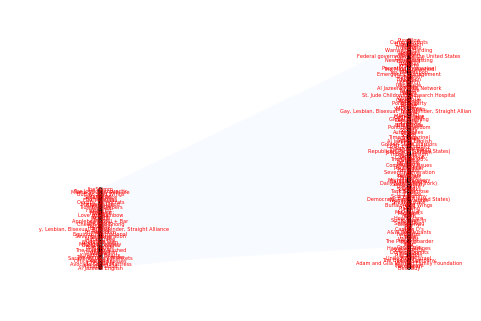

In [42]:
pos = dict()
pos.update((n, (0, i*10)) for i, n in enumerate(X))
pos.update((n, (5, i*10)) for i, n in enumerate(Y))
#num_edges = G.number_of_edges()
#num_nodes = G.number_of_nodes()

#edges = G.edges()
#colors = [G[u][v]['color'] for u,v in edges]
#weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos=pos, with_labels=False,
        edge_color=np.array(list(nx.get_edge_attributes(G, "weight").values())), 
        edge_cmap=plt.get_cmap('Blues'), 
        width=np.array(list(nx.get_edge_attributes(G, "weight").values())), 
        node_color=np.random.random(num_nodes),
        node_size=10,
        cmap=plt.get_cmap('Reds'))


full_keyword_list = list(df_Index_perfect_norm.columns.values) + list(df_ads_topics_perfect_norm.columns.values)
labels = {}    
for counter, node in enumerate(G.nodes()):
    labels[node] = full_keyword_list[counter]

    
# Maybe `pos`     
    
nx.draw_networkx_labels(G,pos,labels,font_size=5,font_color='r')
plt.show()

In [96]:
pos

{0: (5, 0),
 1: (0, 0),
 2: (5, 10),
 3: (0, 10),
 4: (5, 20),
 5: (0, 20),
 6: (5, 40),
 7: (0, 30),
 8: (0, 40),
 9: (0, 50),
 10: (0, 60),
 11: (5, 90),
 12: (0, 70),
 13: (0, 80),
 14: (0, 90),
 15: (0, 100),
 16: (0, 110),
 17: (5, 130),
 18: (0, 120),
 19: (0, 130),
 20: (0, 140),
 21: (0, 150),
 22: (0, 160),
 23: (0, 170),
 24: (0, 180),
 25: (0, 190),
 26: (0, 200),
 27: (0, 210),
 28: (0, 220),
 29: (5, 190),
 30: (0, 230),
 31: (0, 240),
 32: (0, 250),
 33: (0, 260),
 34: (0, 270),
 35: (0, 280),
 36: (0, 290),
 'The Penny Hoarder': (5, 230),
 38: (0, 300),
 39: (0, 310),
 40: (0, 320),
 41: (0, 330),
 42: (0, 340),
 43: (0, 350),
 44: (0, 360),
 45: (5, 280),
 46: (0, 370),
 47: (5, 300),
 48: (0, 380),
 49: (0, 390),
 50: (5, 330),
 51: (0, 400),
 52: (0, 410),
 53: (0, 420),
 54: (0, 430),
 'Wave': (5, 360),
 56: (0, 440),
 57: (0, 450),
 58: (5, 390),
 59: (0, 460),
 60: (0, 470),
 61: (5, 420),
 62: (0, 480),
 63: (0, 490),
 64: (5, 450),
 65: (5, 460),
 66: (5, 470),
 